In [1]:
import os
import pandas as pd
import numpy as np
import statistics
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from citipy import citipy

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100


ten_year_source = os.path.join('EF_Data_Sets', '2008-2019_combined.xls')
ten_year_df = pd.read_excel(ten_year_source)

current_year_source = os.path.join('EF_Data_Sets', 'index2019_data.xls')

mmxix = os.path.join('CIA_Info', '2019_CIA_factbook.json')
with open(mmxix, encoding = 'utf8') as jsonfile:
    cia_facts = json.load(jsonfile)

In [2]:
region_col = [1, 3]
region_df = pd.read_excel(current_year_source, usecols = region_col)
region_df.rename(columns = {"Country Name": "name", "Region": "region"}, inplace = True)

In [3]:
primary_df = pd.merge(ten_year_df, region_df,  how = 'outer', on = 'name')

In [4]:
# Slice 2019 from primary_df AS A COPY, as not to modify primary_df

df_2019 = primary_df[primary_df['index year'] == 2019].copy(deep = True)

# pull list of country names for data cleaning
series = df_2019['name']
country_names = []

for name in series:
    country_names.append(name)

# drop space from last character of name string
end_space_dropped = []

for name in country_names:
    if name[-1] == ' ':
        end_clean = name[:-1]
        end_space_dropped.append(end_clean)        
    else:
        end_space_dropped.append(name)                

In [5]:
# fill spaces and replace hyphens with '_' and misc data cleaning
search_country = []

for name in end_space_dropped:
    spacefill = name.replace(' ', '_')
    formatted = spacefill.replace('-', '_')
    if formatted[:4] == 'The_':
        cleaned = formatted[4:] + '_The'
        search_country.append(cleaned)
    elif 'Congo' in formatted:
        if 'Democratic' in formatted:
            cleaned = 'Congo_Democratic_Republic_of_The'
            search_country.append(cleaned)
        else:
            cleaned = 'Congo_Republic_of_The'
            search_country.append(cleaned)                  
    elif 'Korea' in formatted:
        if 'South' in formatted:
            cleaned = 'Korea_South'
            search_country.append(cleaned)
        else:
            cleaned = 'Korea_North'
            search_country.append(cleaned)
    elif 'CÃ´' in formatted:
        cleaned = "Cote_d'_Ivoire"
        search_country.append(cleaned)
    elif 'Kyrgyz' in formatted:
        cleaned = 'Kyrgyzstan'
        search_country.append(cleaned)
    elif 'SÃ£o' in formatted:
        cleaned = 'Sao_Tome_and_Principe'
        search_country.append(cleaned)
    elif 'Brunei' in formatted:
        cleaned = 'Brunei'
        search_country.append(cleaned)
    elif 'Czech' in formatted:
        cleaned = 'Czechia'
        search_country.append(cleaned)
    elif 'Macedonia' in formatted:
        cleaned = 'North_Macedonia'
        search_country.append(cleaned)
    elif 'Micronesia' in formatted:
        cleaned = 'Micronesia_Federated_States_of'
        search_country.append(cleaned)
    else:
        search_country.append(formatted)     

df_2019['search key'] = search_country

In [6]:
name = []
pop = []
gvt = []
gdpv = []
gdpy = []
gdpr = []
gdppc = []
gdppcMATH = []
gdppy = []
gdppr = []

for country in search_country: 
    try:
        access_country = cia_facts['countries'][country.lower()]
        name.append(country)

        population = access_country['data']['people']['population']['total']
        pop.append(population)

        form_of_government = access_country['data']['government']['government_type']
        gvt.append(form_of_government)                                          

        gdp_value = (int(access_country
                        ['data']['economy']['gdp']['purchasing_power_parity']['annual_values'][0]['value'])/
                            1000000000)
        gdpv.append(gdp_value)

        gdp_year = (access_country['data']['economy']['gdp']['purchasing_power_parity']['annual_values'][0]['date'])
        gdpy.append(gdp_year)      

        gdp_rank = access_country['data']['economy']['gdp']['purchasing_power_parity']['global_rank']    
        gdpr.append(gdp_rank)

        gdp_per_cap_round = (int(access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']
                                               ['annual_values'][0]['value']))
        gdppc.append(gdp_per_cap_round)

        gdp_per_cap_MATH = (gdp_value*1000000000)/population
        gdppcMATH.append(gdp_per_cap_MATH)        

        gdp_per_cap_year = (access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']
                                          ['annual_values'][0]['date'])
        gdppy.append(gdp_per_cap_year)

        gdp_per_cap_rank = access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']['global_rank']    
        gdppr.append(gdp_per_cap_rank)
        
    except KeyError:
        percapgdp = (gdp_value*1000000000)/population
        gdppc.append(percapgdp)
        gdppcMATH.append(percapgdp)        
        gdppy.append(gdp_year)
        gdppr.append('200')

In [7]:
cia_df = (pd.DataFrame(list(zip(name, pop, gvt, gdpv, gdpy, gdpr, gdppc, gdppy, gdppcMATH, gdppr)), 
          columns = ['search key', 'population', 'form of government', 'gdp (bil. usd)', 'gdp year', 'gdp rank', 
                     'per capita gdp (usd)', 'per capita gdp year', 'calculated per capita gdp (usd)', 'per capita rank']))

current_year_all_data_df = df_2019.merge(cia_df, how = 'outer', on = 'search key').drop(columns=['search key'])
# current_year_all_data_df

In [8]:
## TOP 5 EFI COUNTRIES 2019
china_df = current_year_all_data_df[current_year_all_data_df['name'] == 'China']
us_df = current_year_all_data_df[current_year_all_data_df['name'] == 'United States']
india_df = current_year_all_data_df[current_year_all_data_df['name'] == 'India']
japan_df = current_year_all_data_df[current_year_all_data_df['name'] == 'Japan']
germany_df = current_year_all_data_df[current_year_all_data_df['name'] == 'Germany']

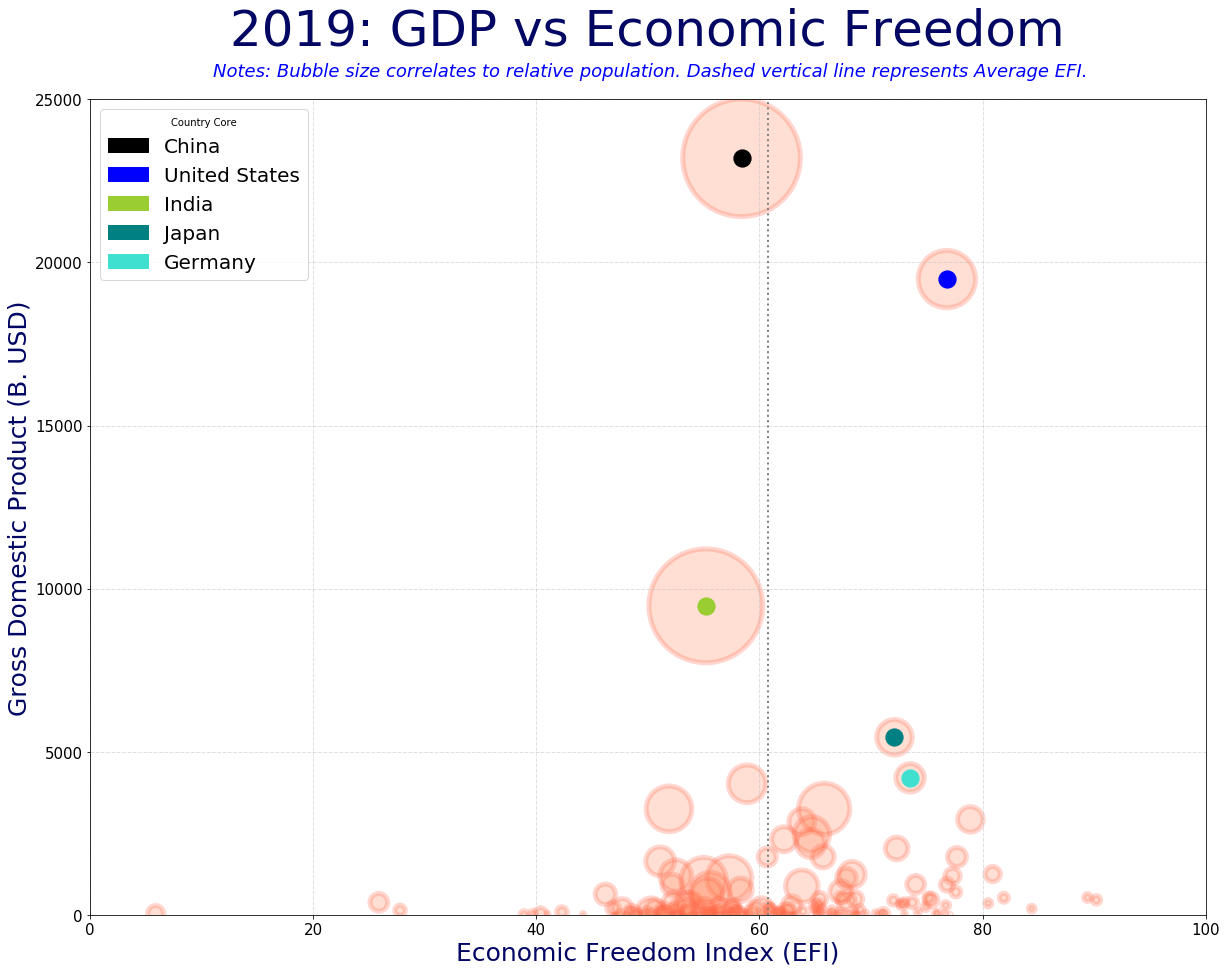

In [9]:
# SCATTER: GDP v EFI

plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: GDP vs Economic Freedom', fontsize = 50, color = 'xkcd:darkblue', pad = 55)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25, color = 'xkcd:darkblue')
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Gross Domestic Product (B. USD)', fontsize = 25, color = 'xkcd:darkblue')
plt.ylim (0, 25000)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 

# PLOT DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

plt.scatter(china_df['overall score'], china_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'black', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(us_df['overall score'], us_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(india_df['overall score'], india_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'yellowgreen', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(japan_df['overall score'], japan_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'teal', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(germany_df['overall score'], germany_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'turquoise', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, 25700, bubble_size, fontsize = 18, color = 'blue', style = 'italic', wrap = True)

# Add legend.
china_patch = mpatches.Patch(color='black', label='China')
us_patch = mpatches.Patch(color='blue', label='United States')
india_patch = mpatches.Patch(color='yellowgreen', label='India')
japan_patch = mpatches.Patch(color='teal', label='Japan')
germany_patch = mpatches.Patch(color='turquoise', label='Germany')

(plt.legend(title='Country Core', 
            handles=[china_patch, us_patch, india_patch, japan_patch, germany_patch], 
            fontsize = 20, 
            loc='upper left'))

plt.savefig((f'PLOT - GDPvEconFreedom.png'))
plt.show()

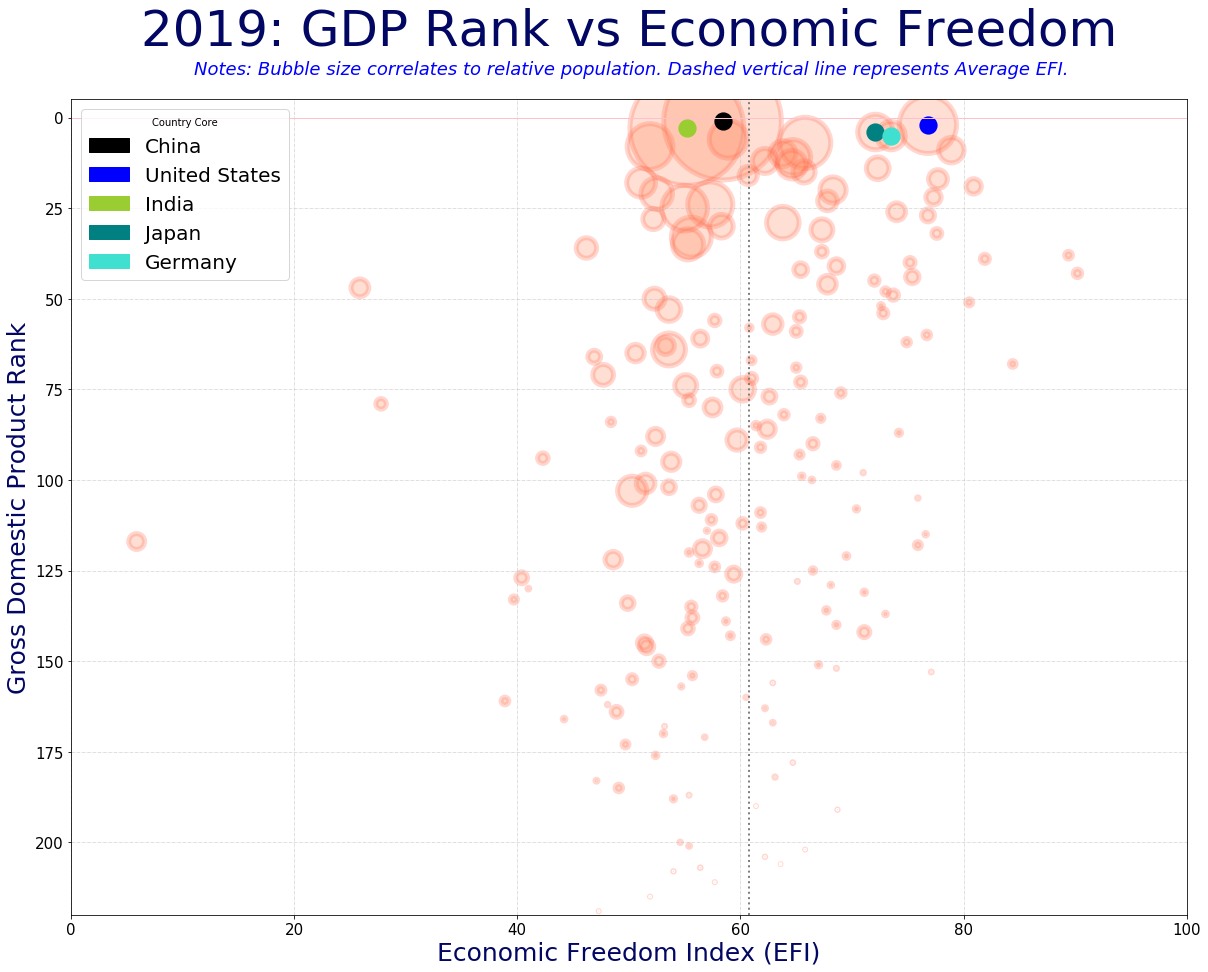

In [10]:
# SCATTER: GDP RANK v EFI

plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: GDP Rank vs Economic Freedom', fontsize = 50, color = 'xkcd:darkblue', pad = 55)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25, color = 'xkcd:darkblue')
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Gross Domestic Product Rank', fontsize = 25, color = 'xkcd:darkblue')
plt.ylim (220, -5)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 
plt.axhline(0, lw = 1, c = 'pink') 


# PLOT DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['gdp rank'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

plt.scatter(china_df['overall score'], china_df['gdp rank'], 
            marker = 'o', 
            c = 'black', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(us_df['overall score'], us_df['gdp rank'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(india_df['overall score'], india_df['gdp rank'], 
            marker = 'o', 
            c = 'yellowgreen', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(japan_df['overall score'], japan_df['gdp rank'], 
            marker = 'o', 
            c = 'teal', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(germany_df['overall score'], germany_df['gdp rank'], 
            marker = 'o', 
            c = 'turquoise', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, -12, bubble_size, fontsize = 18, color = 'blue', style = 'italic', wrap = True)

# Add legend.
us_patch = mpatches.Patch(color='blue', label='United States')
china_patch = mpatches.Patch(color='black', label='China')
india_patch = mpatches.Patch(color='yellowgreen', label='India')
japan_patch = mpatches.Patch(color='teal', label='Japan')
germany_patch = mpatches.Patch(color='turquoise', label='Germany')

(plt.legend(title='Country Core', 
            handles=[china_patch, us_patch, india_patch, japan_patch, germany_patch], 
            fontsize = 20, 
            loc='upper left'))

plt.savefig((f'PLOT - GDPRankvEconFreedom.png'))
plt.show()

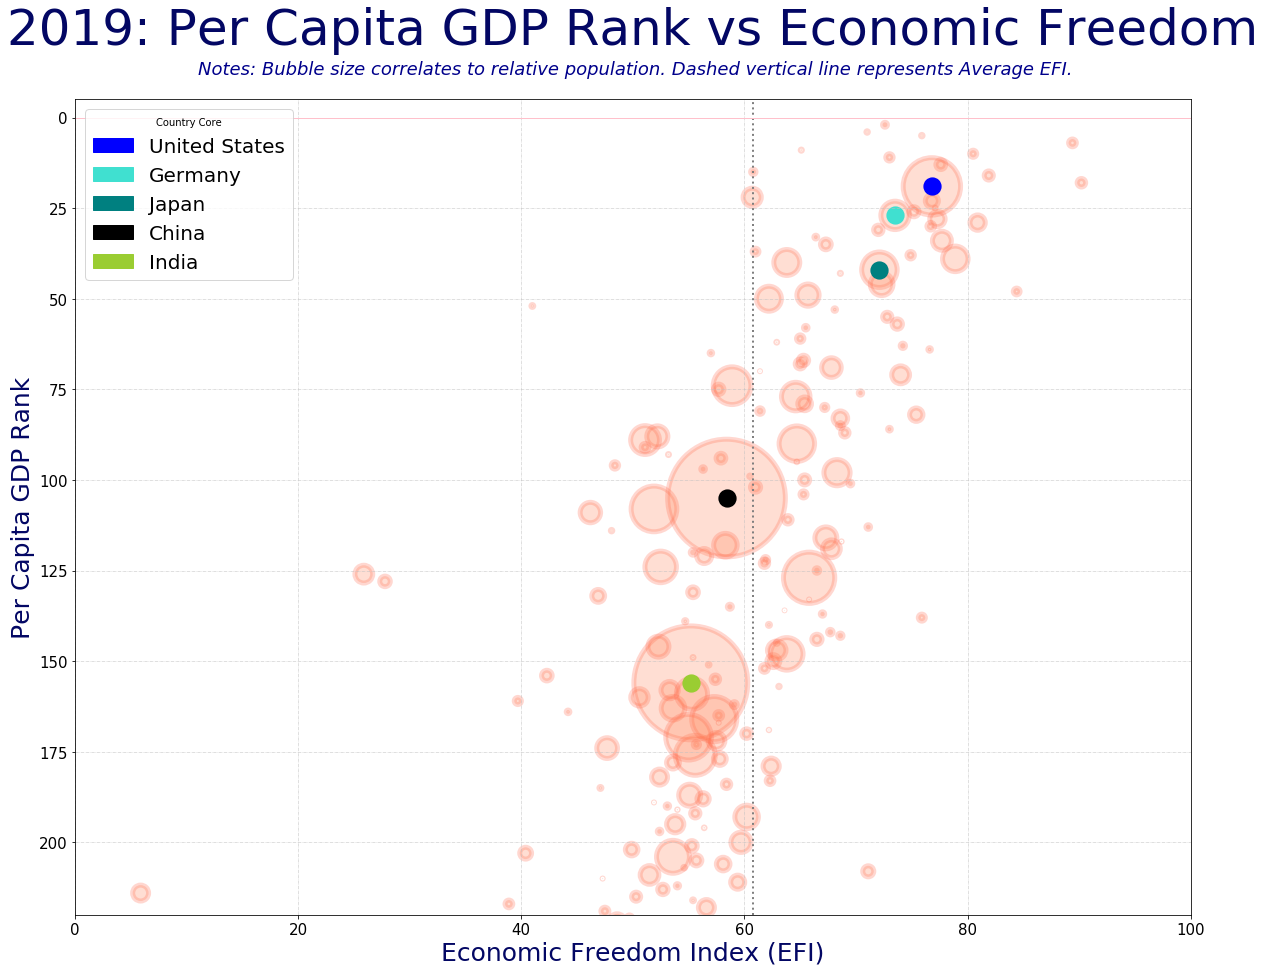

In [11]:
# SCATTER: GDP PER CAPITA RANK v EFI

plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: Per Capita GDP Rank vs Economic Freedom', fontsize = 50, color = 'xkcd:darkblue', pad = 55)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25, color = 'xkcd:darkblue')
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Per Capita GDP Rank', fontsize = 25, color = 'xkcd:darkblue')
plt.ylim (220, -5)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 
plt.axhline(0, lw = 1, c = 'pink') 


# PLOT DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['per capita rank'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

plt.scatter(china_df['overall score'], china_df['per capita rank'], 
            marker = 'o', 
            c = 'black', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(us_df['overall score'], us_df['per capita rank'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(india_df['overall score'], india_df['per capita rank'], 
            marker = 'o', 
            c = 'yellowgreen', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(japan_df['overall score'], japan_df['per capita rank'], 
            marker = 'o', 
            c = 'teal', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(germany_df['overall score'], germany_df['per capita rank'], 
            marker = 'o', 
            c = 'turquoise', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, -12, bubble_size, fontsize = 18, color = 'darkblue', style = 'italic', wrap = True)

# Add legend.
us_patch = mpatches.Patch(color='blue', label='United States')
china_patch = mpatches.Patch(color='black', label='China')
india_patch = mpatches.Patch(color='yellowgreen', label='India')
japan_patch = mpatches.Patch(color='teal', label='Japan')
germany_patch = mpatches.Patch(color='turquoise', label='Germany')

(plt.legend(title='Country Core', 
            handles=[us_patch, germany_patch, japan_patch, china_patch, india_patch], 
            fontsize = 20, 
            loc='upper left'))

plt.savefig((f'PLOT - PerCapGDPvEconFreedom.png'))
plt.show()

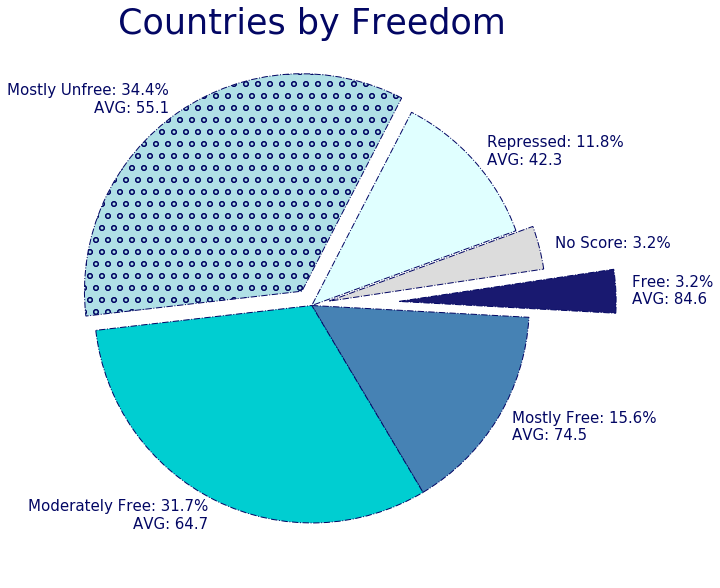

In [12]:
# PIE: PERCENTAGE OF COUNTRIES BY FREEDOM

free = []
mfree = []
moderate = []
munfree = []
repressed = []
unscored = []

score_free = []
score_mfree = []
score_moderate = []
score_munfree = []
score_repressed = []

reference = list(zip(current_year_all_data_df['name'], current_year_all_data_df['overall score']))

for item in reference:
    if item[1] >= 80:
        free.append(item[0])
        score_free.append(item[1])
    elif item[1] >= 70 and item[1] < 80:
        mfree.append(item[0])
        score_mfree.append(item[1])    
    elif item[1] >= 60 and item[1] < 70:
        moderate.append(item[0])
        score_moderate.append(item[1])        
    elif item[1] >= 50 and item[1] < 60:
        munfree.append(item[0])
        score_munfree.append(item[1])    
    elif item[1] >= 1 and item[1] < 50:
        repressed.append(item[0])
        score_repressed.append(item[1])        
    else:
        unscored.append(item[0])
        
country_count = len(reference)

classifications = [len(free), len(mfree), len(moderate), len(munfree), len(repressed), len(unscored)]
freedom_labels = ([(f'Free: {round(classifications[0]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_free), 1)}'), 
                   (f'Mostly Free: {round(classifications[1]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_mfree), 1)}'), 
                   (f'Moderately Free: {round(classifications[2]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_moderate), 1)}'), 
                   (f'Mostly Unfree: {round(classifications[3]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_munfree), 1)}'), 
                   (f'Repressed: {round(classifications[4]/country_count*100, 1)}%\nAVG: {round(statistics.mean(score_repressed), 1)}'), 
                   (f'No Score: {round(classifications[5]/country_count*100, 1)}%')])


freedom_colors = (['#191970',  # Midnight Blue
                   '#4682B4',  # Steel Blue
                   '#00CED1',  # Dark Turquoise
                   '#B0E0E6',  # Powder Blue
                   '#E0FFFF',  # Light Cyan
                   '#DCDCDC']) # Gainsboro

fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title('Countries by Freedom', fontsize = 35, pad = 0, color = 'xkcd:darkblue')
ax.set(aspect = 'equal')

patches = plt.pie(classifications, 
        labels = freedom_labels, 
        labeldistance = 1.075, 
        textprops = {'fontsize': 15, 'color': 'xkcd:darkblue'}, 
        wedgeprops = {'edgecolor': 'xkcd:darkblue', 'linewidth': 1, 'linestyle': '-.', 'hatch': '', 'antialiased': True}, 
        colors = freedom_colors, 
        counterclock = False, 
        startangle = 8.5, 
        explode = (.4, .0, .0, .08, .0, 0.08), 
        shadow = False)[0]

patches[0].set_hatch('')
patches[3].set_hatch('o')

plt.savefig((f'PIE - CountriesbyFreedom.png'))
plt.show()